It's the DESC Hack day for the 2018 Summer meeting. I'm going to work on the "Will it blend?" classifier. I'm going to use the matched catalogs in DC2 to construct this. 

It's possible there are other issues with these catalogs that make this not possible. If this is the case, it is worthwile to know, too. 

In [136]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs

In [138]:
# load coadd catalog (for a single tract)
coadd_cat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p_tract4850')

In [139]:
# Let's choose a small RA and Dec range to do the matching so that it won't take too long!
ra_min, ra_max = 55.0, 60.0
dec_min, dec_max = -29.0, -24.0

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

In [140]:
# Let's also define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 24.5',
]

In [141]:
# Load ra and dec from coadd, using both of the filters we just defined
coadd_coord = coadd_cat.get_quantities(['ra', 'dec'], filters=(coord_filters + mag_filters))

In [142]:
# Let's now turn to the truth catalog, turn of md5 sum check to save time
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.1', {'md5': None})

In [166]:
redshifts = truth_cat.get_quantities('redshift', filters =mag_filters, native_filters=(coord_filters + ['i < 24.5']))

In [ ]:
delta = []
for i1 in range(redshifts['redshift'].shape[0]):
    for i2 in range(i1+1, redshifts['redshift'].shape[0]):
        delta.append(np.log10(np.abs(redshifts['redshift'][i1] - redshifts['redshift'][i2])+1e-9) )
        
delta = np.array(delta)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


In [143]:
# to make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', 'i')

In [144]:
# get ra and dec from truth catalog
# note that we add i < 24.5 to the native filter to speed up load time
truth_coord = truth_cat.get_quantities(['ra','dec'], filters=mag_filters, native_filters=(coord_filters + ['i < 24.5']))

In [145]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_coord, 'coadd': coadd_coord},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [146]:
from collections import Counter, defaultdict

In [147]:
def retrieve_subset_by_count(results, selected_quantities, n_true, n_coadd):
    # now we want to count the number of truth and coadd objects *for each group*
    # but instead of looping over groups, we can do this in a smart (and very fast) way

    # first we need to know which rows are from the truth catalog and which are from the coadd
    truth_mask = results['catalog_key'] == 'truth'
    coadd_mask = ~truth_mask
    
    truth_group_counter = Counter(results['group_id'][truth_mask])
    coadd_group_counter = Counter(results['group_id'][coadd_mask])
    #select blended groups
    # wish I could do this faster
    matched_groups = set()
    for group_id, true_count in truth_group_counter.items():
        if true_count != n_true:
            continue

        coadd_count = coadd_group_counter[group_id]
        if coadd_count != n_coadd:
            continue

        matched_groups.add(group_id)
        
    # get ra and dec from truth catalog
    # note that we add i < 24.5 to the native filter to speed up load time
    truth_vals= truth_cat.get_quantities(selected_quantities,\
                                         filters=mag_filters,\
                                         native_filters=(coord_filters + ['i < 24.5']))
    matched_vals = defaultdict(list)

    for row in results[truth_mask]:
        if row['group_id'] in matched_groups:
            idx = row['row_index']
            matched_vals[row['group_id']].append([truth_vals[key][idx] for key in selected_quantities] )

    return matched_vals

In [148]:
selected_quantities = ['ra','dec','u','g','r','i','z','redshift']
blended_pairs = retrieve_subset_by_count(results, selected_quantities, 2,1)

In [149]:
# now I need to get an idea for what distributions of objects can be blended so I can make
# an initial cut. 

ang_dists = []
for pairs in blended_pairs.values():
    ra1, dec1 = pairs[0][:2]
    ra2, dec2 = pairs[1][:2]
    ang_dists.append(np.sqrt((ra1-ra2)**2+(dec1-dec2)**2))
    
ang_dists = np.array(ang_dists)

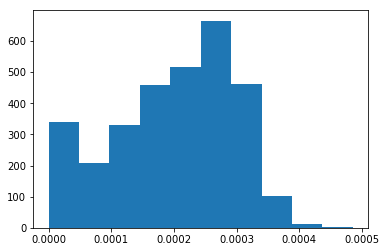

In [150]:
plt.hist(ang_dists);

In [151]:
max_ang_dist = ang_dists.max()

In [152]:
from sklearn.neighbors import KDTree

In [153]:
selected_quantities = ['ra','dec','u','g','r','i','z','redshift']

_unblended_objs = retrieve_subset_by_count(results, selected_quantities, 1,1)

In [154]:
unblended_objs = np.r_[[np.array(v[0]) for v in _unblended_objs.values()] ]

In [155]:
# now make kdtree to find pairs on unblended objects 
kdtree = KDTree(unblended_objs[:, :2])

unblended_neighbors = kdtree.query_radius(unblended_objs[:,:2], r = max_ang_dist)

In [156]:
unblended_pairs = []
seen_objs = set()
for row in unblended_neighbors:
    if row.shape[0]  == 2:
        if all(i in seen_objs for i in row):
            continue
        unblended_pairs.append(list(unblended_objs[row[0]]) )
        unblended_pairs[-1].extend(unblended_objs[row[1]])
        
        for i in row:
            seen_objs.add(i)
            
unblended_pairs = np.array(unblended_pairs)

In [157]:
_blended_pairs = []

for row in blended_pairs.values():
    _blended_pairs.append(row[0])
    _blended_pairs[-1].extend(row[1])
    
blended_pairs = np.array(_blended_pairs)

In [158]:
unblended_pairs[0]

array([ 56.15565235, -28.33495934,  23.36393637,  23.38526388,
        23.08607278,  22.38352663,  22.19934844,   0.76339829,
        56.155615  , -28.3346321 ,  28.05006019,  25.55044486,
        24.34336383,  23.28025177,  22.79261058,   0.        ])

In [159]:
total_points = len(blended_pairs) + len(unblended_pairs)
# do I want to add difference columns?
# will add a distance column
x = np.zeros((total_points, unblended_pairs.shape[1] -3)) 
y = np.zeros((total_points,), dtype = bool)

In [160]:
n_blended = blended_pairs.shape[0]
n_params = len(selected_quantities)
x[:n_blended, :n_params-2] = blended_pairs[:,2:n_params]
x[:n_blended, n_params-2:-1] = blended_pairs[:, n_params+2:]
x[:n_blended, -1] = np.sqrt( \
                    (blended_pairs[:, 0]-blended_pairs[:, n_params+0])**2 +
                    (blended_pairs[:, 1]-blended_pairs[:, n_params+1])**2 ) 

x[n_blended:, :n_params-2] = unblended_pairs[:, 2:n_params]
x[n_blended:, n_params-2:-1] = unblended_pairs[:, n_params+2:]
x[n_blended:, -1] =  np.sqrt( \
                    (unblended_pairs[:, 0]-unblended_pairs[:, n_params+0])**2 +
                    (unblended_pairs[:, 1]-unblended_pairs[:, n_params+1])**2 ) 

In [161]:
y[:n_blended] = True

In [162]:
np.save('blended_props.npy', x)
np.save('blended_bool.npy', y)

In [163]:
x.shape

(4652, 13)